In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ================================
# CONFIG & LOAD DATA
# ================================
TARGET = "NObeyesdad"

train = pd.read_csv("/kaggle/input/ai-201-b-mse-2-aiml-a/train.csv")
test  = pd.read_csv("/kaggle/input/ai-201-b-mse-2-aiml-a/test.csv")

train_df = train.copy()
test_df  = test.copy()

# ================================
# 1️⃣ Split X & y
# ================================
X = train_df.drop(columns=[TARGET])
y = train_df[TARGET]

# ================================
# 2️⃣ Numeric & Categorical Columns
# ================================
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

# ================================
# 3️⃣ Missing value imputation
# ================================
num_imputer = SimpleImputer(strategy="median")
X[num_cols] = num_imputer.fit_transform(X[num_cols])
test_df[num_cols] = num_imputer.transform(test_df[num_cols])

cat_imputer = SimpleImputer(strategy="most_frequent")
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])
test_df[cat_cols] = cat_imputer.transform(test_df[cat_cols])

# ================================
# 4️⃣ Outlier Capping (Method 1 - IQR)
# Capping separately per category
# ================================
def cap_iqr_categorywise(df, cat_cols, num_cols):
    df = df.copy()
    
    def cap_group(group):
        group = group.copy()
        for col in num_cols:
            Q1 = group[col].quantile(0.25)
            Q3 = group[col].quantile(0.75)
            IQR = Q3 - Q1
            low = Q1 - 1.5 * IQR
            high = Q3 + 1.5 * IQR
            group[col] = group[col].clip(low, high)
        return group
    
    for c in cat_cols:
        df = df.groupby(c, group_keys=False, observed=True).apply(cap_group)
    
    return df


print("Capping Outliers...")
X = cap_iqr_categorywise(X, cat_cols, num_cols)

# ================================
# 5️⃣ One-Hot Encoding
# ================================
print("Encoding categorical columns...")
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

X_cat = ohe.fit_transform(X[cat_cols])
test_cat = ohe.transform(test_df[cat_cols])

X_cat_df = pd.DataFrame(X_cat, index=X.index, columns=ohe.get_feature_names_out(cat_cols))
test_cat_df = pd.DataFrame(test_cat, index=test_df.index, columns=ohe.get_feature_names_out(cat_cols))

X = pd.concat([X.drop(columns=cat_cols), X_cat_df], axis=1)
test_df = pd.concat([test_df.drop(columns=cat_cols), test_cat_df], axis=1)

# ================================
# 6️⃣ Standard Scaler
# ================================
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

# ================================
# 7️⃣ Train/Valid split
# ================================
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ================================
# 8️⃣ RandomForest + RandomSearch
# ================================
rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced"
)

param_dist = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [None, 10, 20 ,25 ],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=25,
    cv=cv,
    scoring="f1_macro",
    random_state=42,
    verbose=1,
    n_jobs=-1
)

print("\nTraining RandomForest...")
search.fit(X_train, y_train)

best_model = search.best_estimator_
print("\nBest Parameters:", search.best_params_)
print("="*70)

# ================================
# 9️⃣ Validation Metrics
# ================================
pred_valid = best_model.predict(X_valid)

print("Validation Accuracy:", accuracy_score(y_valid, pred_valid))
print("Macro F1:", f1_score(y_valid, pred_valid, average='macro'))
print(classification_report(y_valid, pred_valid))

# ================================
# 🔟 Predict on Test
# ================================
test_probs = best_model.predict_proba(test_df)
classes = best_model.classes_

submission = pd.DataFrame(test_probs, columns=[f"{TARGET}_{c}" for c in classes])
submission.insert(0, "id", test['id'])

submission.to_csv("submission.csv", index=False)
print("\nsubmission.csv saved!")


Numeric columns: 8
Categorical columns: 8
Capping Outliers...


/tmp/ipykernel_47/4160543497.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(c, group_keys=False, observed=True).apply(cap_group)
/tmp/ipykernel_47/4160543497.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(c, group_keys=False, observed=True).apply(cap_group)
/tmp/ipykernel_47/4160543497.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colu

Encoding categorical columns...

Training RandomForest...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/tmp/ipykernel_47/4160543497.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(c, group_keys=False, observed=True).apply(cap_group)
/tmp/ipykernel_47/4160543497.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(c, group_keys=False, observed=True).apply(cap_group)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was 


Best Parameters: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25}
Validation Accuracy: 0.8686510103768432
Macro F1: 0.8568294471509051
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.87      0.90       443
      Normal_Weight       0.81      0.83      0.82       544
     Obesity_Type_I       0.86      0.85      0.86       520
    Obesity_Type_II       0.96      0.95      0.95       570
   Obesity_Type_III       0.99      0.99      0.99       712
 Overweight_Level_I       0.73      0.75      0.74       434
Overweight_Level_II       0.73      0.74      0.74       439

           accuracy                           0.87      3662
          macro avg       0.86      0.86      0.86      3662
       weighted avg       0.87      0.87      0.87      3662



ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- id


Dataset loaded successfully!

Checking null values...

Gender                            1235
Age                               1811
Height                            1604
Weight                            1468
family_history_with_overweight    1065
FAVC                              1049
FCVC                               975
NCP                               1720
CAEC                              1465
SMOKE                             1547
CH2O                               933
SCC                               1803
FAF                               1724
TUE                               1120
CALC                              1090
MTRANS                            1089
NObeyesdad                           0
dtype: int64


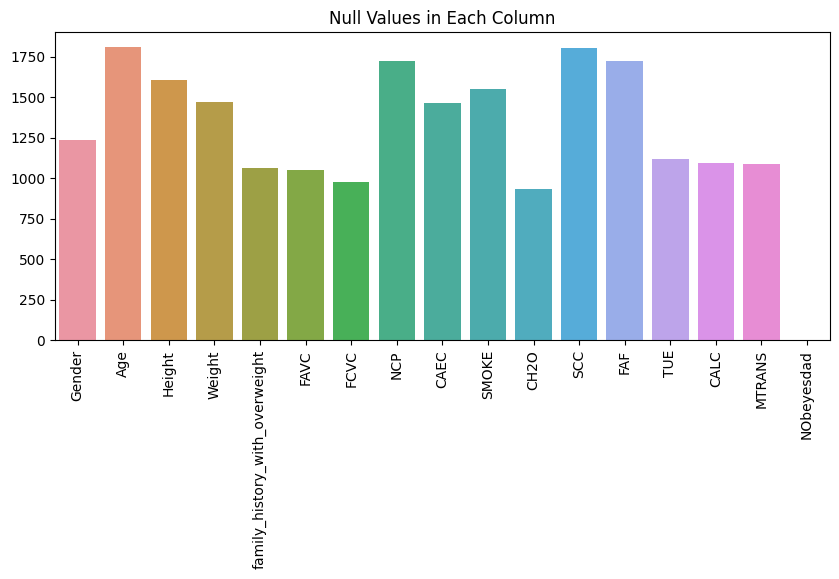

Numeric columns: 8
Categorical columns: 8

Plotting numeric distributions...



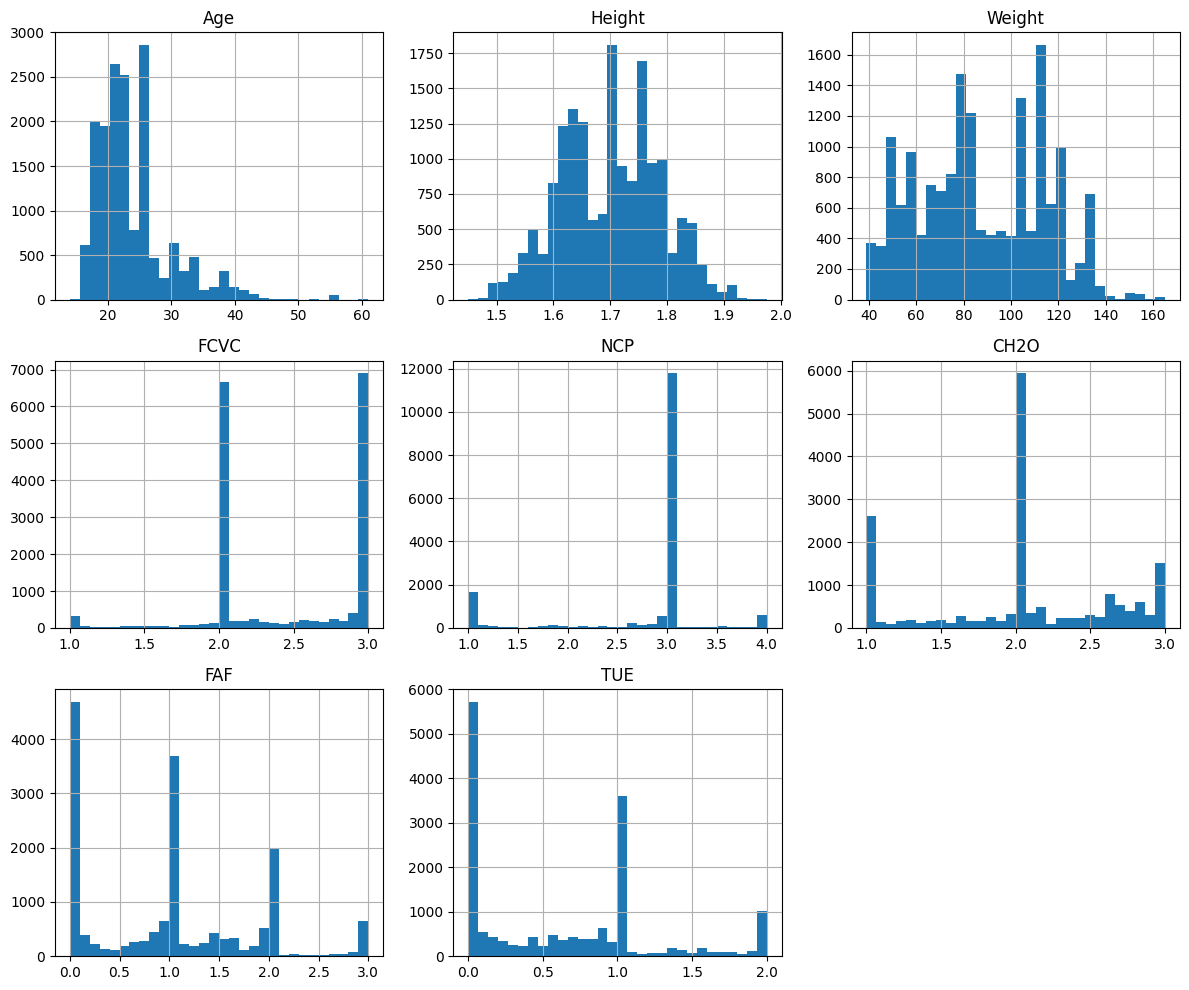


Plotting category-wise countplots...



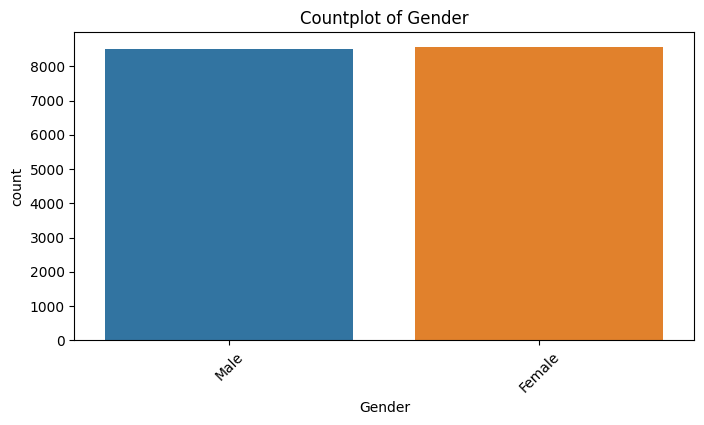

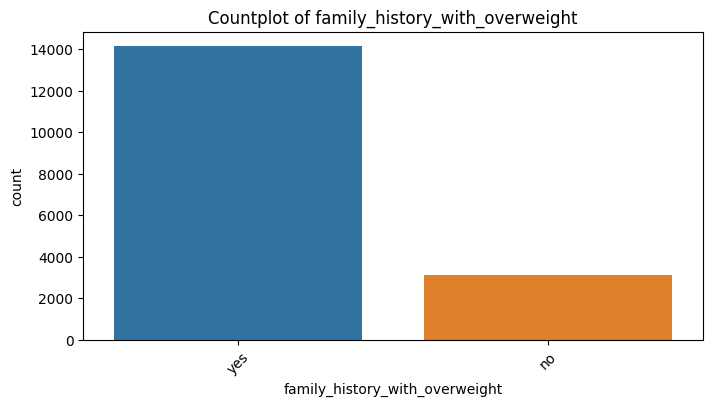

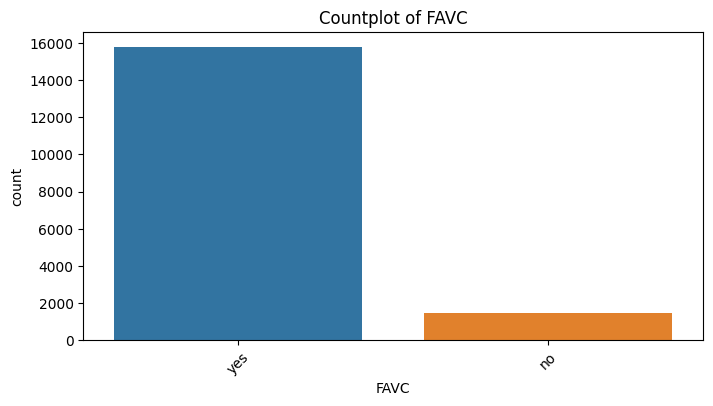

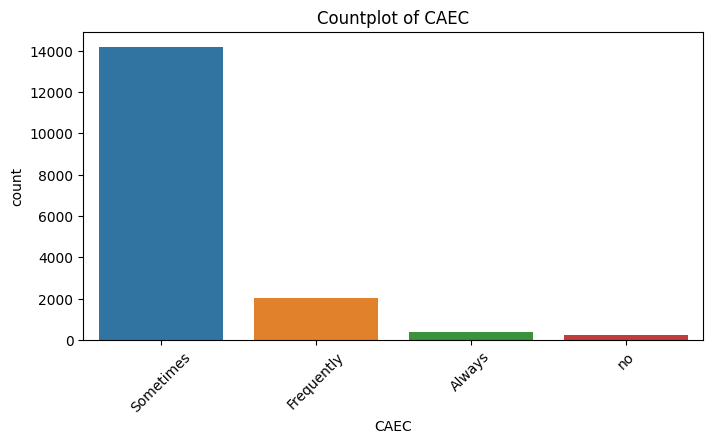

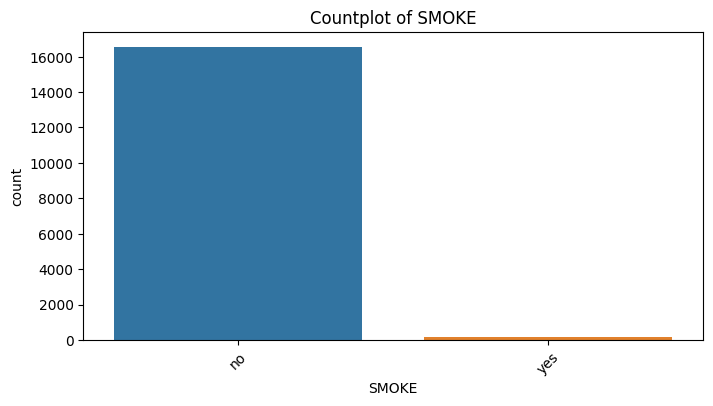

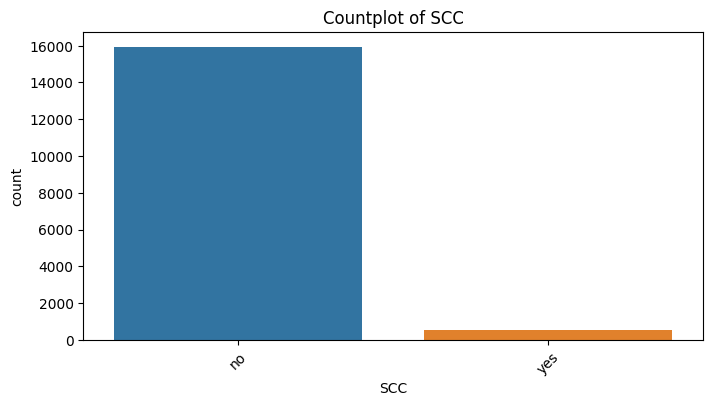

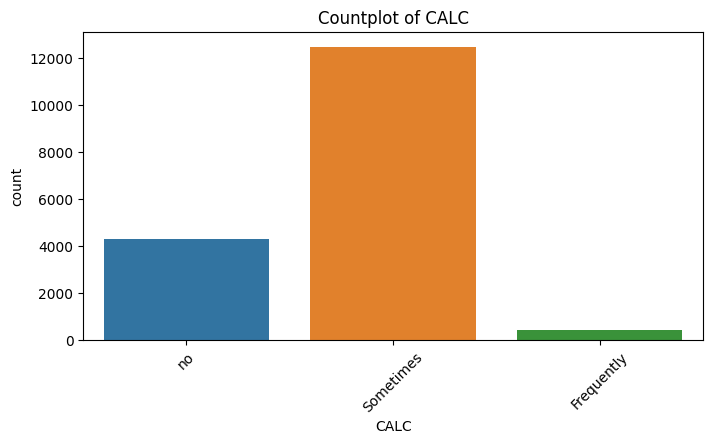

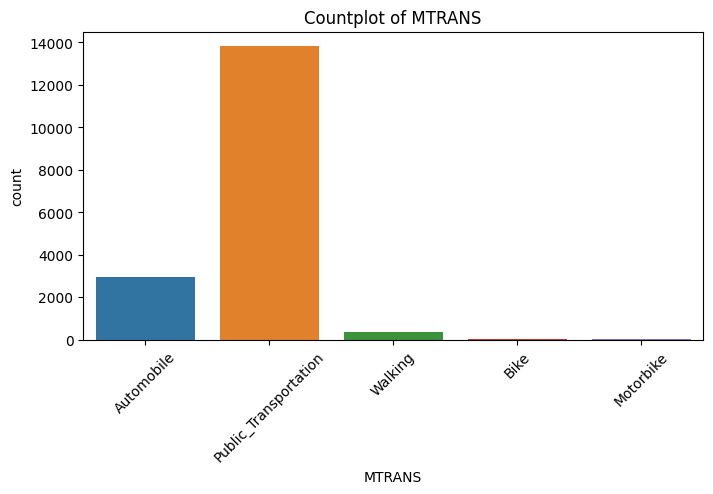


Plotting numeric outliers (boxplots)...



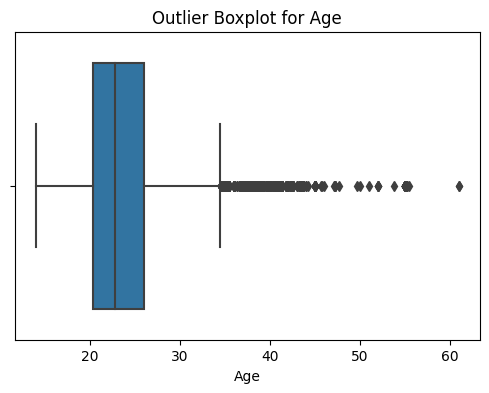

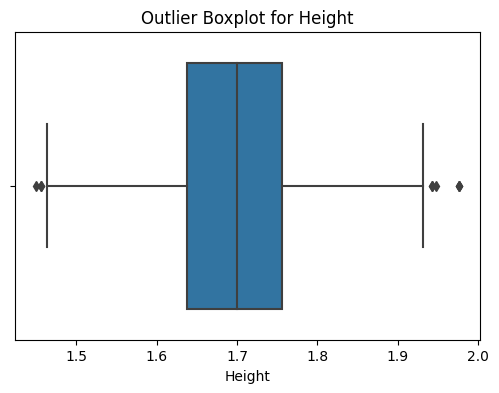

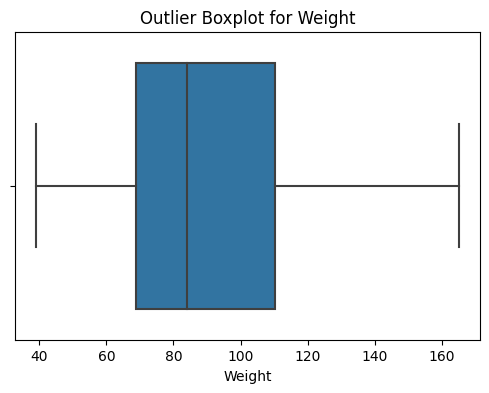

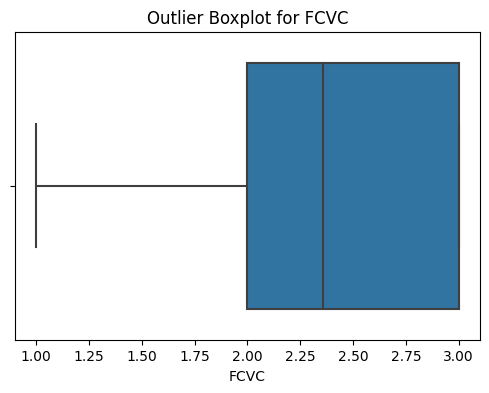

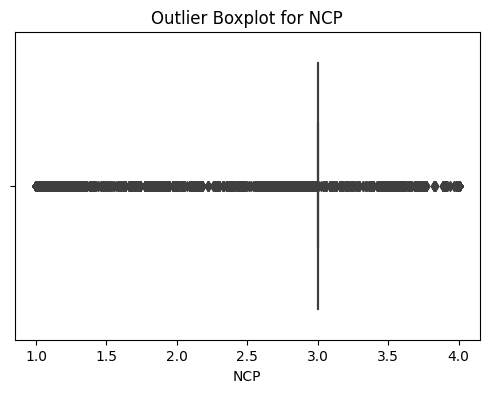

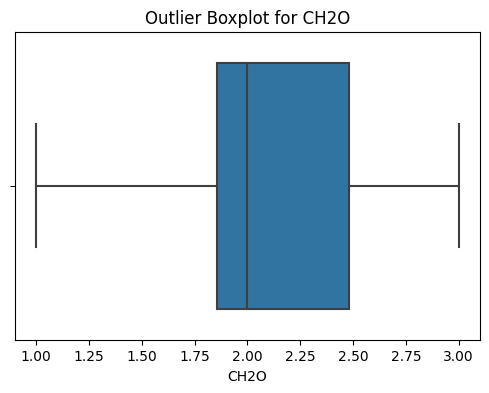

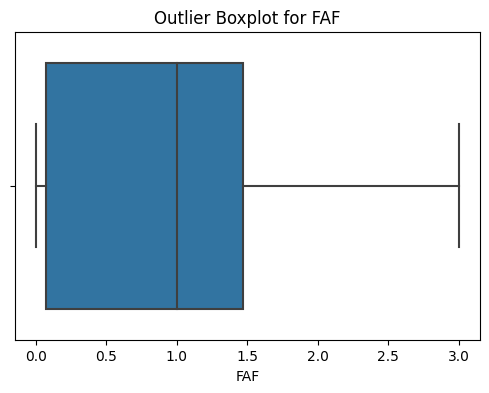

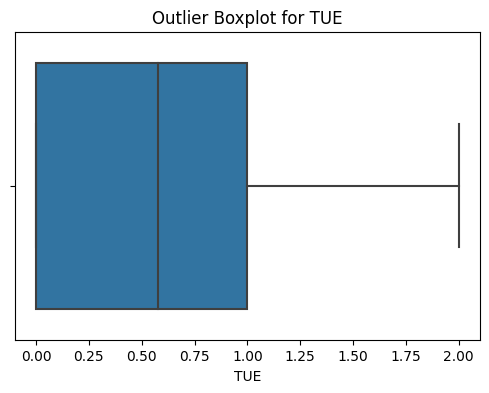

Capping Outliers...


/tmp/ipykernel_47/1859770493.py:109: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(c, group_keys=False, observed=True).apply(cap_group)
/tmp/ipykernel_47/1859770493.py:109: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(c, group_keys=False, observed=True).apply(cap_group)
/tmp/ipykernel_47/1859770493.py:109: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping c

Encoding categorical columns...

Training RandomForest...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/tmp/ipykernel_47/1859770493.py:109: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(c, group_keys=False, observed=True).apply(cap_group)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Best Parameters: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25}


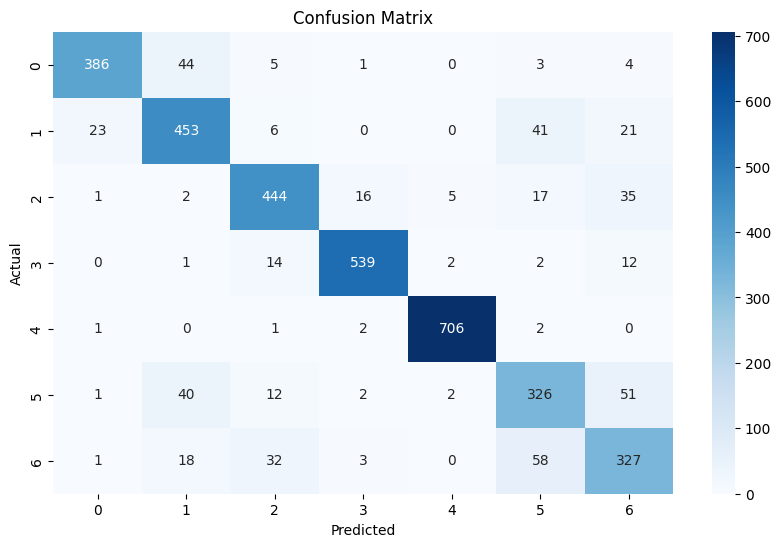

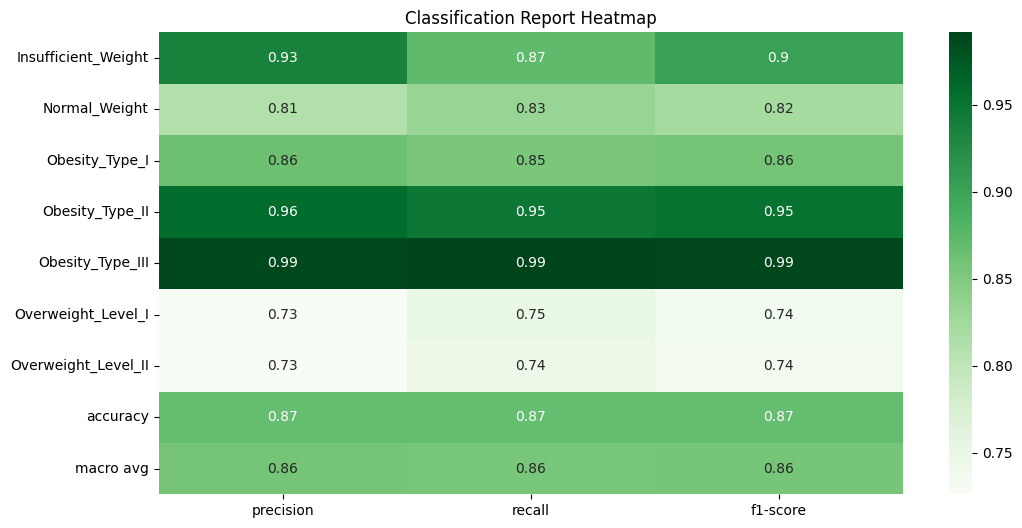

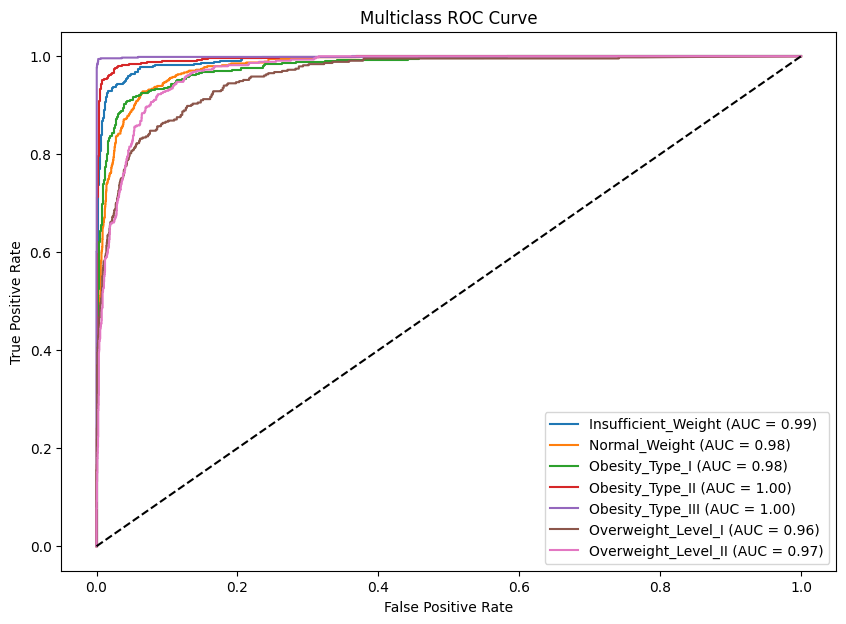

Validation Accuracy: 0.8686510103768432
Macro F1: 0.8568294471509051
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.87      0.90       443
      Normal_Weight       0.81      0.83      0.82       544
     Obesity_Type_I       0.86      0.85      0.86       520
    Obesity_Type_II       0.96      0.95      0.95       570
   Obesity_Type_III       0.99      0.99      0.99       712
 Overweight_Level_I       0.73      0.75      0.74       434
Overweight_Level_II       0.73      0.74      0.74       439

           accuracy                           0.87      3662
          macro avg       0.86      0.86      0.86      3662
       weighted avg       0.87      0.87      0.87      3662


submission.csv saved!


In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns


# ================================
# CONFIG & LOAD DATA
# ================================
TARGET = "NObeyesdad"

train = pd.read_csv("/kaggle/input/ai-201-b-mse-2-aiml-a/train.csv")
test  = pd.read_csv("/kaggle/input/ai-201-b-mse-2-aiml-a/test.csv")

train_df = train.copy()
test_df  = test.copy()
print("Dataset loaded successfully!")

# Drop ID from test BEFORE processing
test_id = test_df["id"]
test_df = test_df.drop(columns=["id"])
# 🔍 EDA PART 1: NULL VALUE TABLE + BAR PLOT
# ==========================================
print("\nChecking null values...\n")
nulls = train_df.isnull().sum()

print(nulls)

plt.figure(figsize=(10,4))
sns.barplot(x=nulls.index, y=nulls.values)
plt.xticks(rotation=90)
plt.title("Null Values in Each Column")
plt.show()
# ================================
# 1️⃣ Split X & y
# ================================
X = train_df.drop(columns=[TARGET])
y = train_df[TARGET]

# ================================
# 2️⃣ Numeric & Categorical Columns
# ================================
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))
# ==========================================
# 🔍 EDA PART 2: NUMERICAL COLUMN DISTRIBUTIONS
# ==========================================
print("\nPlotting numeric distributions...\n")
X[num_cols].hist(bins=30, figsize=(12,10))
plt.tight_layout()
plt.show()
# 🔍 EDA PART 3: CATEGORY-WISE DISTRIBUTION (COUNT PLOTS)
# ==========================================
print("\nPlotting category-wise countplots...\n")
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=X, x=col)
    plt.xticks(rotation=45)
    plt.title(f"Countplot of {col}")
    plt.show()

# ================================
# 3️⃣ Missing value imputation
# ================================
num_imputer = SimpleImputer(strategy="median")
X[num_cols] = num_imputer.fit_transform(X[num_cols])
test_df[num_cols] = num_imputer.transform(test_df[num_cols])

cat_imputer = SimpleImputer(strategy="most_frequent")
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])
test_df[cat_cols] = cat_imputer.transform(test_df[cat_cols]) 

# 🔍 EDA PART 4: OUTLIER BOXPLOTS FOR NUMERIC COLUMNS
# ==========================================
print("\nPlotting numeric outliers (boxplots)...\n")
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=X[col])
    plt.title(f"Outlier Boxplot for {col}")
    plt.show()
# ================================
# 4️⃣ Outlier Capping Category-wise
# ================================
def cap_iqr_categorywise(df, cat_cols, num_cols):
    df = df.copy()
    
    def cap_group(group):
        group = group.copy()
        for col in num_cols:
            Q1 = group[col].quantile(0.25)
            Q3 = group[col].quantile(0.75)
            IQR = Q3 - Q1
            low = Q1 - 1.5 * IQR
            high = Q3 + 1.5 * IQR
            group[col] = group[col].clip(low, high)
        return group
    
    for c in cat_cols:
        df = df.groupby(c, group_keys=False, observed=True).apply(cap_group)
    
    return df

print("Capping Outliers...")
X = cap_iqr_categorywise(X, cat_cols, num_cols)

# ================================
# 5️⃣ One-Hot Encoding
# ================================
print("Encoding categorical columns...")
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

X_cat = ohe.fit_transform(X[cat_cols])
test_cat = ohe.transform(test_df[cat_cols])

X_cat_df = pd.DataFrame(X_cat, index=X.index, columns=ohe.get_feature_names_out(cat_cols))
test_cat_df = pd.DataFrame(test_cat, index=test_df.index, columns=ohe.get_feature_names_out(cat_cols))

X = pd.concat([X.drop(columns=cat_cols), X_cat_df], axis=1)
test_df = pd.concat([test_df.drop(columns=cat_cols), test_cat_df], axis=1)

# ================================
# 6️⃣ Standard Scaler
# ================================
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

# ================================
# 7️⃣ Train/Valid split
# ================================
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ================================
# 8️⃣ RandomForest + RandomSearch
# ================================
rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced"
)

param_dist = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [None, 10, 20, 25],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=25,
    cv=cv,
    scoring="f1_macro",
    random_state=42,
    verbose=1,
    n_jobs=-1
)

print("\nTraining RandomForest...")
search.fit(X_train, y_train)

best_model = search.best_estimator_
print("\nBest Parameters:", search.best_params_)
print("="*70)

# ================================
# 9️⃣ Validation Metrics
# ================================
pred_valid = best_model.predict(X_valid)
# ==========================================
# 🔵 CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_valid, pred_valid)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==========================================
# 🔵 CLASSIFICATION REPORT HEATMAP
# ==========================================
report = classification_report(y_valid, pred_valid, output_dict=True)
report_df = pd.DataFrame(report).T

plt.figure(figsize=(12,6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Greens")
plt.title("Classification Report Heatmap")
plt.show()

# ==========================================
# 🔵 MULTICLASS ROC CURVE (One-vs-Rest)
# ==========================================

y_valid_bin = label_binarize(y_valid, classes=best_model.classes_)
valid_probs = best_model.predict_proba(X_valid)

plt.figure(figsize=(10,7))

for i, cls in enumerate(best_model.classes_):
    fpr, tpr, _ = roc_curve(y_valid_bin[:, i], valid_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.title("Multiclass ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


print("Validation Accuracy:", accuracy_score(y_valid, pred_valid))
print("Macro F1:", f1_score(y_valid, pred_valid, average='macro'))
print(classification_report(y_valid, pred_valid))

# ==================================================
# 🔟 FIX: Make sure test_df columns match training
# ==================================================
test_df = test_df[X_train.columns]

# ================================
# 🔟 Predict on Test
# ================================
test_probs = best_model.predict_proba(test_df)
classes = best_model.classes_

submission = pd.DataFrame(test_probs, columns=[f"{TARGET}_{c}" for c in classes])
submission.insert(0, "id", test_id)

submission.to_csv("submission.csv", index=False)
print("\nsubmission.csv saved!")


In [2]:
pd.read_csv('/kaggle/working/submission.csv')

,id,NObeyesdad_Insufficient_Weight,NObeyesdad_Normal_Weight,NObeyesdad_Obesity_Type_I,NObeyesdad_Obesity_Type_II,NObeyesdad_Obesity_Type_III,NObeyesdad_Overweight_Level_I,NObeyesdad_Overweight_Level_II
0,1,0.000000,0.000999,0.004219,0.000000,0.994781,0.000000,0.000000
1,2,0.170357,0.508037,0.023942,0.000357,0.000165,0.182274,0.114868
2,3,0.065155,0.021467,0.616804,0.064171,0.074851,0.076597,0.080955
3,4,0.000000,0.000882,0.094317,0.865703,0.001667,0.004901,0.032530
4,5,0.463260,0.369924,0.012505,0.000000,0.000000,0.117046,0.037264
...,...,...,...,...,...,...,...,...
4147,4148,0.247273,0.744831,0.000000,0.000000,0.000000,0.006298,0.001598
4148,4149,0.004642,0.003818,0.803212,0.053567,0.024013,0.040684,0.070063
4149,4150,0.000732,0.000038,0.976908,0.000000,0.000628,0.006821,0.014873
4150,4151,0.012284,0.046332,0.117707,0.022240,0.000000,0.457192,0.344245


In [3]:
# Predict class labels
test_pred = best_model.predict(test_df)

# Build submission
submission = pd.DataFrame({
    "id": test_id,
    TARGET: test_pred
})

submission.to_csv("verma.csv", index=False)
print("Submission saved!")





# test_probs = best_model.predict_proba(test_df)
# classes = best_model.classes_

# submission = pd.DataFrame(test_probs, columns=[f"{TARGET}_{c}" for c in classes])
# submission.insert(0, "id", test_id)

# submission.to_csv("submission.csv", index=False)
# print("\nsubmission.csv saved!")

Submission saved!


In [4]:
pd.read_csv('/kaggle/working/verma.csv')

,id,NObeyesdad
0,1,Obesity_Type_III
1,2,Normal_Weight
2,3,Obesity_Type_I
3,4,Obesity_Type_II
4,5,Insufficient_Weight
...,...,...
4147,4148,Normal_Weight
4148,4149,Obesity_Type_I
4149,4150,Obesity_Type_I
4150,4151,Overweight_Level_I
